# An Empirical Approach to Dreidel
I generated some driedel data using [this script](https://github.com/zrottman/dreidel-simulator) I built. Now it's time to get to the bottom of how long (i.e., how many spins o' the dreidel) a typical game takes based on two variables: the number of players and each player's starting bankroll amount.

This dataset contains games involving 2-6 players, and starting bankrolls from 3–10 units. For each player-bankroll combination, I've run 3,000 simulations. So we've got 120,000 game simulations in all.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dreidel = pd.read_csv('../data/dreidel_data3.csv')
dreidel.head()

,players,bankroll_start,winner,rounds,spins
0,2,3,player1,4,6
1,2,3,player1,4,6
2,2,3,player2,3,3
3,2,3,player1,5,7
4,2,3,player1,4,6


In [37]:
# Define custom palette
colors = ['#233D4D', '#FE7F2D', '#FCCA46', '#A1C181', '#619B8A', '#1E91D6']

mypalette = sns.set_palette(sns.color_palette(colors))
sns.color_palette(colors)

[(0.13725490196078433, 0.23921568627450981, 0.30196078431372547),
 (0.996078431372549, 0.4980392156862745, 0.17647058823529413),
 (0.9882352941176471, 0.792156862745098, 0.27450980392156865),
 (0.6313725490196078, 0.7568627450980392, 0.5058823529411764),
 (0.3803921568627451, 0.6078431372549019, 0.5411764705882353),
 (0.11764705882352941, 0.5686274509803921, 0.8392156862745098)]

## Takeaway #1: Death by a Thousand Spins

First things first. How many spins does a typical game take? Too damn many!

Let's take a look at the distribution of spin counts for a subset of the data--say, games with 4 players and starting bankrolls ranging from 5–10 units.

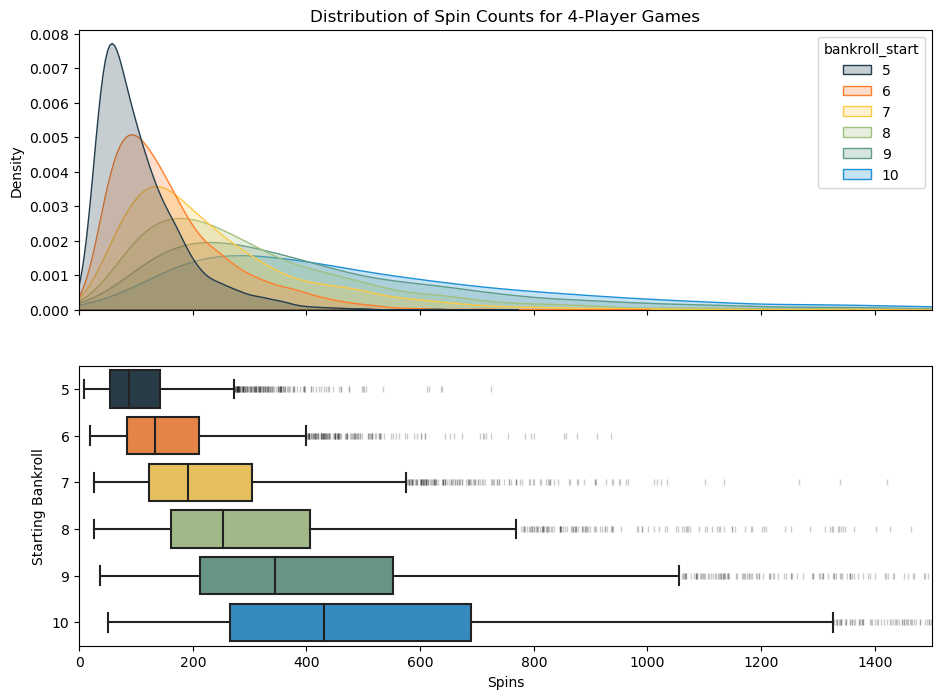

In [66]:
# Subset dataframe
df = dreidel[(dreidel['players'] == 4) & (dreidel['bankroll_start'] >= 5)]

fig, axs = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

sns.kdeplot(
    x='spins',
    common_norm=False,
    fill=True,
    data=df,
    ax=axs[0],
    #palette='crest'
    hue=df['bankroll_start'].astype('category')
)

sns.boxplot(
    x='spins',
    data=df,
    ax=axs[1],
    showfliers=True,
    flierprops=dict(marker='|', markersize=5, markeredgecolor='black', alpha=.2),
    y='bankroll_start',
    #palette='crest',
    orient='h'
)

axs[0].set_title('Distribution of Spin Counts for 4-Player Games')
axs[1].set_ylabel('Starting Bankroll')
axs[1].set_xlabel('Spins')
axs[1].set_xlim(0, 1500)

plt.savefig(fname='dist_4players.tif', dpi=150, bbox_inches='tight');

We can immediately see that these distributions are positively skewed, meaning that there are games with very high spin counts that are going to bias the mean in that direction. Because of that, I'll rely on the median and interquartile range as better indicators of central tendency and variance, respectively.

Just as a larger bankroll results in longer 4-person games, more players will also result in higher spin counts:

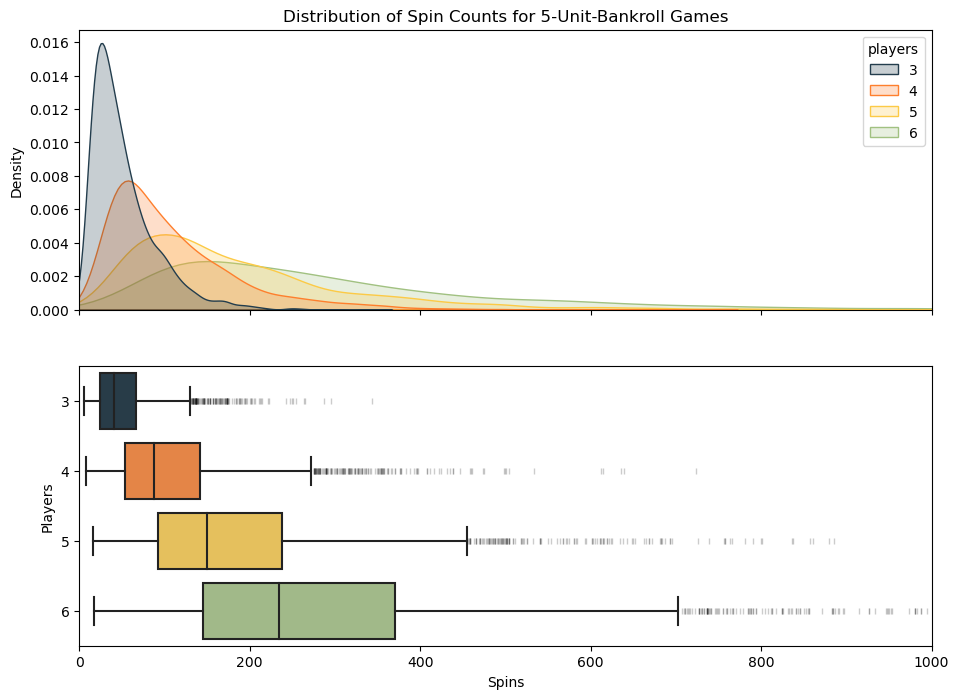

In [67]:
# Subset dataframe
df = dreidel[(dreidel['players'] >= 3) & (dreidel['bankroll_start'] == 5)]

fig, axs = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

sns.kdeplot(
    x='spins',
    common_norm=False,
    fill=True,
    data=df,
    ax=axs[0],
    #palette='crest',
    hue=df['players'].astype('category')
)

sns.boxplot(
    x='spins',
    data=df,
    ax=axs[1],
    showfliers=True,
    flierprops=dict(marker='|', markersize=5, markeredgecolor='black', alpha=.2),
    #palette='crest',
    y='players',
    orient='h'
)

axs[0].set_title('Distribution of Spin Counts for 5-Unit-Bankroll Games')
axs[1].set_ylabel('Players')
axs[1].set_xlabel('Spins')
axs[1].set_xlim(0, 1000)

plt.savefig(fname='dist_5units.tif', dpi=150, bbox_inches='tight');

Putting it all together, here are the spin counts you can expect (i.e., median spin count with error bars indicating the interquartile range) varying both player count and starting bankroll.

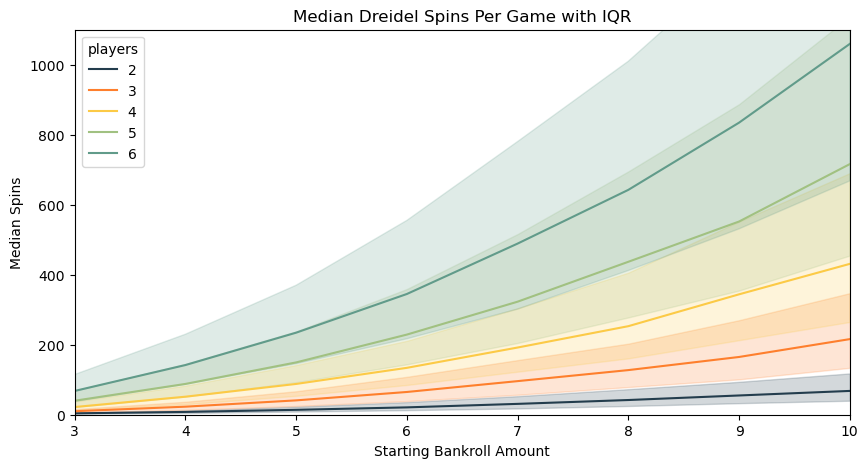

In [68]:
plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=dreidel, 
    x='bankroll_start', 
    y='spins', 
    hue=dreidel['players'].astype('category'), 
    estimator=np.median, 
    #palette='crest',
    errorbar=('pi', 50)
)

plt.title('Median Dreidel Spins Per Game with IQR')
plt.xlabel('Starting Bankroll Amount')
plt.ylabel('Median Spins')
plt.xlim(3, 10)
plt.ylim(0, 1100)
plt.xticks(range(3, 11))

plt.savefig(fname='median_spins.tif', dpi=150, bbox_inches='tight');

That's a lot of spins.

Here'a another way of visualizing the same data with more precise numbers:

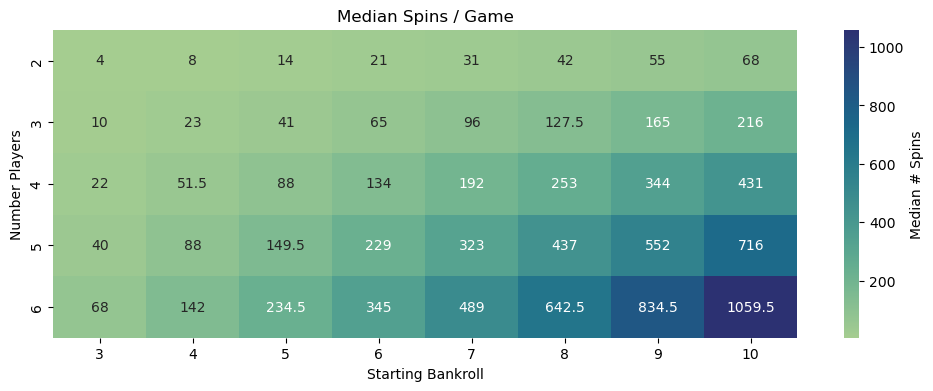

In [69]:
df = dreidel.pivot_table(values='spins', index='players', columns='bankroll_start', aggfunc=np.median)

plt.subplots(figsize=(12, 4))
sns.heatmap(
    data=df,
    cmap='crest',
    annot=True,
    fmt='g',
    cbar_kws={'label':'Median # Spins'}
)
plt.title('Median Spins / Game')
plt.xlabel('Starting Bankroll')
plt.ylabel('Number Players')

plt.savefig(fname='median_spins_heatmap.tif', dpi=150, bbox_inches='tight');

## Takeaway #2: This Game Takes Way Too Damn Long

I'm not sure how many spins per minute a typical dreidel gang completes per minute, but 8 strikes me as a reasonably frenzied pace to sustain. Let's calculate game durations using that as an estimate.

In [51]:
dreidel['est_mins'] = dreidel['spins'] / 8
dreidel.sample(5)

,players,bankroll_start,winner,rounds,spins,est_mins
41046,3,8,player1,16,34,4.250
101152,6,4,player1,117,281,35.125
76393,5,4,player3,46,99,12.375
112480,6,8,player3,133,321,40.125
20614,2,9,player2,77,150,18.750


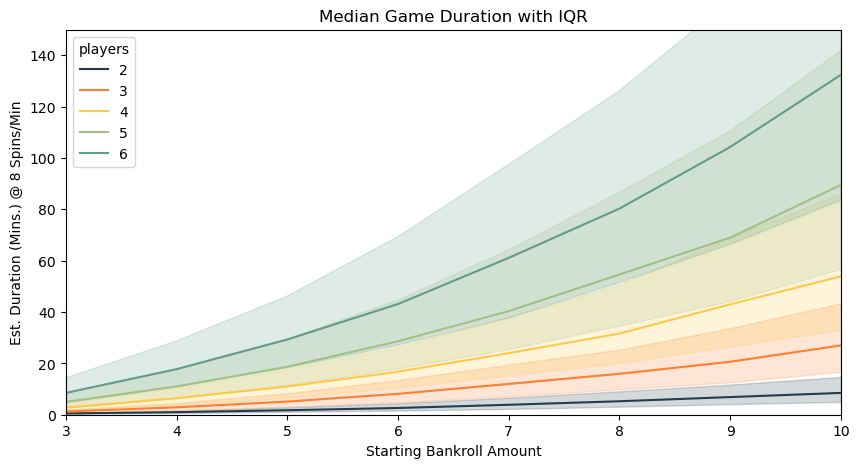

In [70]:
plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=dreidel, 
    x='bankroll_start', 
    y='est_mins', 
    hue=dreidel['players'].astype('category'), 
    estimator=np.median, 
    #palette='crest',
    errorbar=('pi', 50)
)

plt.title('Median Game Duration with IQR')
plt.xlabel('Starting Bankroll Amount')
plt.ylabel('Est. Duration (Mins.) @ 8 Spins/Min')
plt.xlim(3, 10)
plt.ylim(0, 150)
#plt.hlines(y=[60, 120], xmin=0, xmax=10, color='black', ls='--', lw=.5)
plt.xticks(range(3, 11))

plt.savefig(fname='median_game_duration_line.tif', dpi=150, bbox_inches='tight');

There is hope yet! As long as you keep your starting bankroll down and your spins/minute rate up, even a 6-person dreidel sesh can (usually) be wrapped in under 30 minutes. But if four dreidel fanatics get together and start the game with ten pieces of gelt each...yikes. That game could easily be an hour long.

Let's take a closer look at that 4-person scenario. It's Channukah and you and three homies are lookin' for some action. But not too much action. How many pieces of gelt do you each start with?

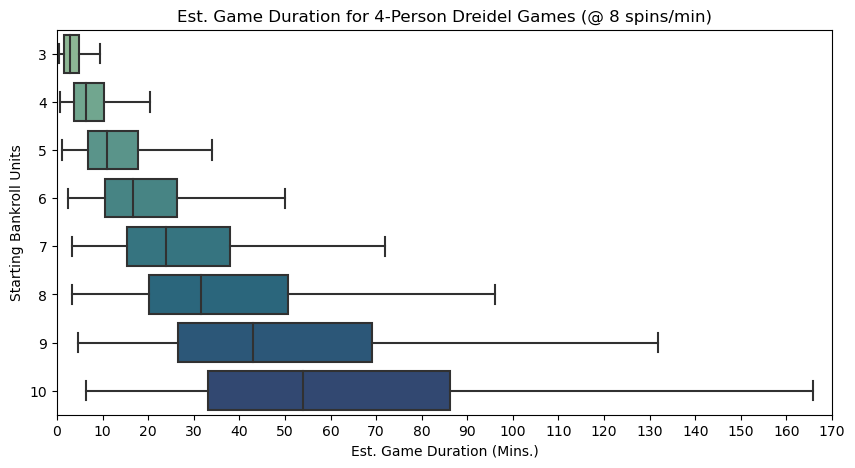

In [71]:
df = dreidel[dreidel['players'] == 4]

plt.subplots(figsize=(10,5))
sns.boxplot(
    data=df,
    x='est_mins',
    y=df['bankroll_start'].astype('category'),
    #hue='players',
    showfliers=False, 
    palette='crest',
    orient='h',
)

plt.title('Est. Game Duration for 4-Person Dreidel Games (@ 8 spins/min)')
plt.xlabel('Est. Game Duration (Mins.)')
plt.ylabel('Starting Bankroll Units')
plt.xlim(0, 170)
plt.xticks(range(0, 171, 10))

plt.savefig(fname='duration_4person.tif', dpi=150, bbox_inches='tight');

As long as the gang can keep twisting 8 times a minute, you should have things wrapped up in a half hour as long as you start with 5 units or less. You're pushing in with 6.

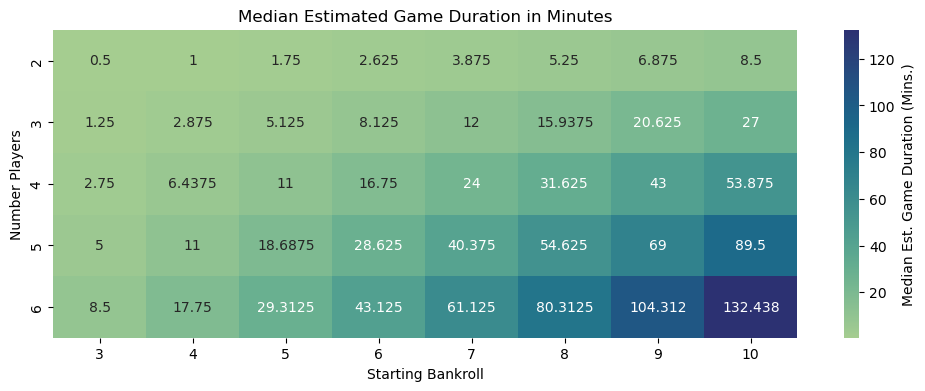

In [72]:
df = dreidel.pivot_table(values='est_mins', index='players', columns='bankroll_start', aggfunc=np.median)

plt.subplots(figsize=(12, 4))
sns.heatmap(
    data=df,
    cmap='crest',
    annot=True,
    fmt='g',
    cbar_kws={'label':'Median Est. Game Duration (Mins.)'}
)
plt.title('Median Estimated Game Duration in Minutes')
plt.xlabel('Starting Bankroll')
plt.ylabel('Number Players')

plt.savefig(fname='duration_heatmap.tif', dpi=150, bbox_inches='tight');

## Takeaway #2: This Game Ain't Fair

Turns out, you spin first, you got the edge. In fact, the earlier you are in the spin order, the better the chance you have at winning it all. Have a look:

In [61]:
# Compute proportion of winners grouped by number of players
df = dreidel.groupby(by=['players'])[['winner']].value_counts(normalize=True).unstack()
df

winner,player1,player2,player3,player4,player5,player6
players,,,,,,
2,0.508000,0.492000,NaN,NaN,NaN,NaN
3,0.374417,0.321833,0.303750,NaN,NaN,NaN
4,0.298208,0.250167,0.229542,0.222083,NaN,NaN
5,0.256000,0.207625,0.191083,0.175917,0.169375,NaN
6,0.229292,0.182375,0.167625,0.149250,0.138583,0.132875


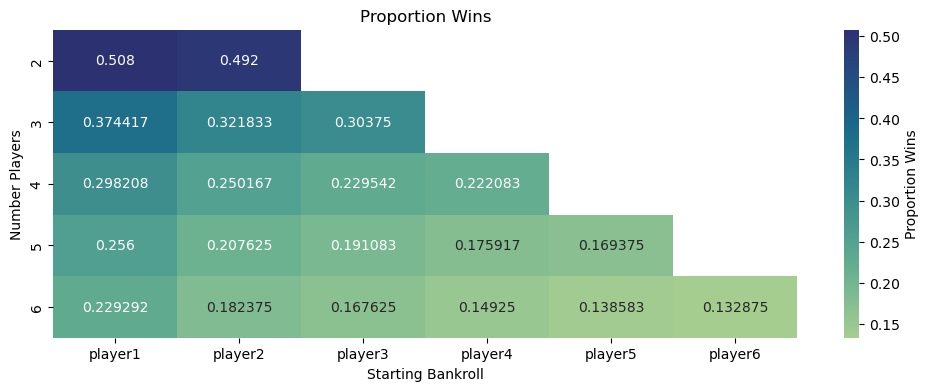

In [62]:
plt.subplots(figsize=(12, 4))
sns.heatmap(
    data=df,
    cmap='crest',
    annot=True,
    fmt='g',
    cbar_kws={'label':'Proportion Wins'}
)
plt.title('Proportion Wins')
plt.xlabel('Starting Bankroll')
plt.ylabel('Number Players');

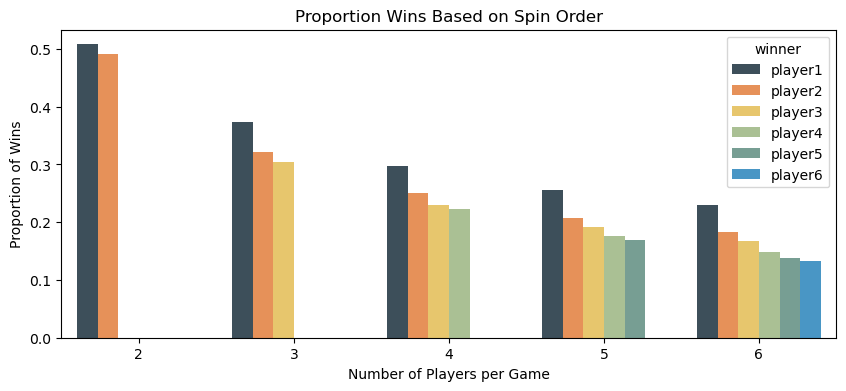

In [73]:
df = dreidel.groupby(by=['players'], as_index=False)[['winner']].value_counts(normalize=True)
plt.subplots(figsize=(10, 4))
sns.barplot(x='players', y='proportion', hue='winner', data=df, alpha=.9)
plt.title('Proportion Wins Based on Spin Order')
plt.xlabel('Number of Players per Game')
plt.ylabel('Proportion of Wins')

plt.savefig(fname='player_win_pct.tif', dpi=150, bbox_inches='tight');

# ETCETCETC

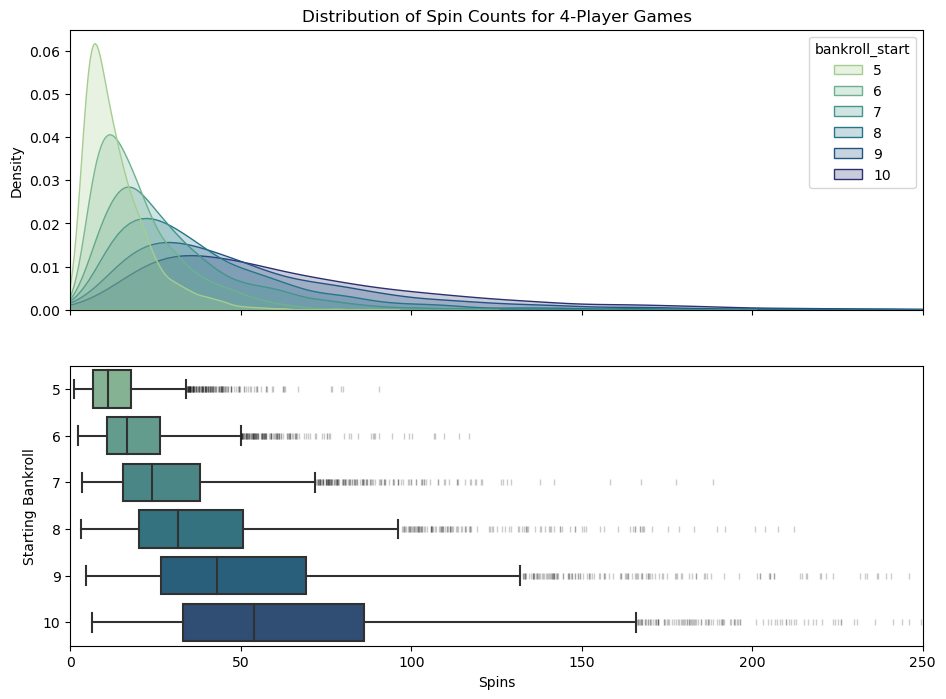

In [30]:
# Subset dataframe
df = dreidel[(dreidel['players'] == 4) & (dreidel['bankroll_start'] >= 5)]

fig, axs = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

sns.kdeplot(
    x='est_mins',
    common_norm=False,
    fill=True,
    data=df,
    ax=axs[0],
    palette='crest',
    hue='bankroll_start'
)

sns.boxplot(
    x='est_mins',
    data=df,
    ax=axs[1],
    showfliers=True,
    flierprops=dict(marker='|', markersize=5, markeredgecolor='black', alpha=.2),
    palette='crest',
    y='bankroll_start',
    orient='h'
)

axs[0].set_title('Distribution of Spin Counts for 4-Player Games')
axs[1].set_ylabel('Starting Bankroll')
axs[1].set_xlabel('Spins')
axs[1].set_xlim(0, 250);

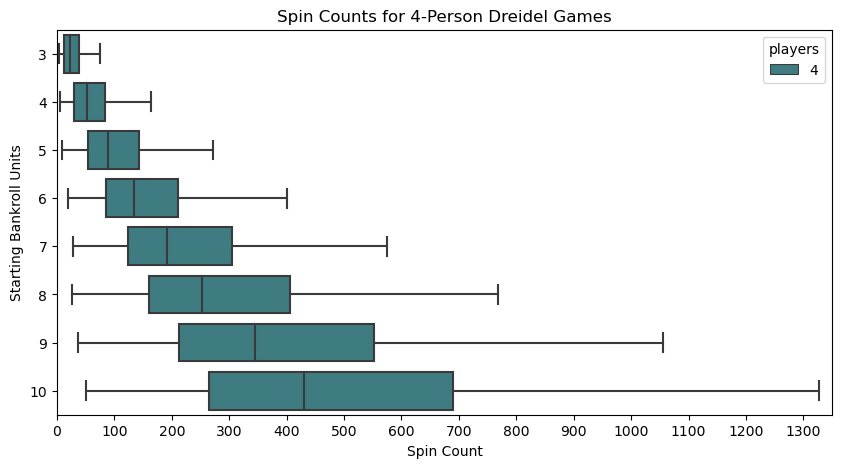

In [6]:
df = dreidel[(dreidel['players'] == 4) & (dreidel['bankroll_start'] < 11)]

plt.subplots(figsize=(10,5))
sns.boxplot(
    data=df,
    x='spins',
    y='bankroll_start',
    hue='players',
    showfliers=False, 
    palette='crest',
    orient='h',
)

plt.title('Spin Counts for 4-Person Dreidel Games')
plt.xlabel('Spin Count')
plt.ylabel('Starting Bankroll Units')
plt.xlim(0, 1350)
plt.xticks(range(0, 1350, 100));

In [7]:
df.groupby(by='bankroll_start')['spins'].describe()

,count,mean,std,min,25%,50%,75%,max
bankroll_start,,,,,,,,
3,3000.0,29.195667,23.115251,4.0,13.0,22.0,38.00,208.0
4,3000.0,64.406000,47.311971,6.0,30.0,51.5,83.25,392.0
5,3000.0,110.155333,80.445939,8.0,54.0,88.0,142.00,724.0
6,3000.0,164.743000,114.746587,19.0,85.0,134.0,211.25,936.0
7,3000.0,238.506333,167.970233,27.0,123.0,192.0,304.25,1509.0
8,3000.0,313.987667,224.596416,26.0,161.0,253.0,406.00,2510.0
9,3000.0,425.398000,300.519545,36.0,213.0,344.0,552.00,2274.0
10,3000.0,530.523000,367.140817,50.0,265.0,431.0,690.25,3566.0


Think 10 pieces of gelt each is reasonable? Think again. If the gang is feeling frenzied and manages to crank that dreidel once every 10 seconds on average, you're still looking at a median game length of 72 minutes to get through all 431 spins. Sure, maybe you guys get lucky and finish in 20 minutes or less—congratulations, you're in the top 5% when it comes to quickest games! But more likely you'll land in the middle 50% of games, which require anywhere from 265 to 690 spins. With your commitment to supersonic dreidling, you'll finish in 45 minutes to 2 hours.

Let's say we're willing to dreidel for a half hour and that we're committing to 6 spins a minute. So, games requiring less than 180 spins. Let's look for a more realistic starting bankroll amount.

In [21]:
sns.color_palette(palette='Accent')

[(0.4980392156862745, 0.788235294117647, 0.4980392156862745),
 (0.7450980392156863, 0.6823529411764706, 0.8313725490196079),
 (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 (1.0, 1.0, 0.6),
 (0.2196078431372549, 0.4235294117647059, 0.6901960784313725),
 (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 (0.7490196078431373, 0.3568627450980392, 0.09019607843137253),
 (0.4, 0.4, 0.4)]

In [22]:

print(sns.color_palette(palette='crest', n_colors=6).as_hex())
sns.color_palette(palette='crest', n_colors=6)

['#7dba91', '#59a590', '#40908e', '#287a8c', '#1c6488', '#254b7f']


[(0.48942421, 0.72854938, 0.56751036),
 (0.34892097, 0.64828676, 0.56513633),
 (0.24929311, 0.56486397, 0.5586654),
 (0.15615526, 0.47913212, 0.54850526),
 (0.11131735, 0.39155635, 0.53422678),
 (0.14573579, 0.29354139, 0.49847009)]

In [23]:
colors = ['#b24c63', '#5438dc', '#357ded', '#56eef4', '#32e875']

mypalette = sns.set_palette(sns.color_palette(colors))
sns.color_palette(colors)

[(0.6980392156862745, 0.2980392156862745, 0.38823529411764707),
 (0.32941176470588235, 0.2196078431372549, 0.8627450980392157),
 (0.20784313725490197, 0.49019607843137253, 0.9294117647058824),
 (0.33725490196078434, 0.9333333333333333, 0.9568627450980393),
 (0.19607843137254902, 0.9098039215686274, 0.4588235294117647)]

In [26]:
colors = ['#377771', '#ed6a5e', '#ffaf87', '#9da589','#ff8e72',   '#4ce0b3', ]

mypalette = sns.set_palette(sns.color_palette(colors))
sns.color_palette(colors)

[(0.21568627450980393, 0.4666666666666667, 0.44313725490196076),
 (0.9294117647058824, 0.41568627450980394, 0.3686274509803922),
 (1.0, 0.6862745098039216, 0.5294117647058824),
 (0.615686274509804, 0.6470588235294118, 0.5372549019607843),
 (1.0, 0.5568627450980392, 0.4470588235294118),
 (0.2980392156862745, 0.8784313725490196, 0.7019607843137254)]

In [22]:
sns.color_palette('Pastel2')

[(0.7019607843137254, 0.8862745098039215, 0.803921568627451),
 (0.9921568627450981, 0.803921568627451, 0.6745098039215687),
 (0.796078431372549, 0.8352941176470589, 0.9098039215686274),
 (0.9568627450980393, 0.792156862745098, 0.8941176470588236),
 (0.9019607843137255, 0.9607843137254902, 0.788235294117647),
 (1.0, 0.9490196078431372, 0.6823529411764706),
 (0.9450980392156862, 0.8862745098039215, 0.8),
 (0.8, 0.8, 0.8)]

In [28]:
# Create custom palette
colors = ['#7FB7BE', '#FF715B', '#F9CB40', '#BCED09', '#2F52E0', '#BF948D']

mypalette = sns.set_palette(sns.color_palette(colors))
sns.color_palette(colors)

[(0.4980392156862745, 0.7176470588235294, 0.7450980392156863),
 (1.0, 0.44313725490196076, 0.3568627450980392),
 (0.9764705882352941, 0.796078431372549, 0.25098039215686274),
 (0.7372549019607844, 0.9294117647058824, 0.03529411764705882),
 (0.1843137254901961, 0.3215686274509804, 0.8784313725490196),
 (0.7490196078431373, 0.5803921568627451, 0.5529411764705883)]

In [23]:
units_10 = (dreidel['bankroll_start'] ==10)

dreidel[players_4 & units_10]['spins'].quantile([.1, .25, .5, .75, .9])

0.10     178.00
0.25     265.00
0.50     431.00
0.75     690.25
0.90    1012.10
Name: spins, dtype: float64

## 1. Case Study: 4-Person Game, 10-Unit Starting Bankroll

To get a better sense of what a distribution of spin counts looks like from this generated dataset, let's start with what I take to be an ordinary dreidle situation: A four-person game where each person starts with ten units.

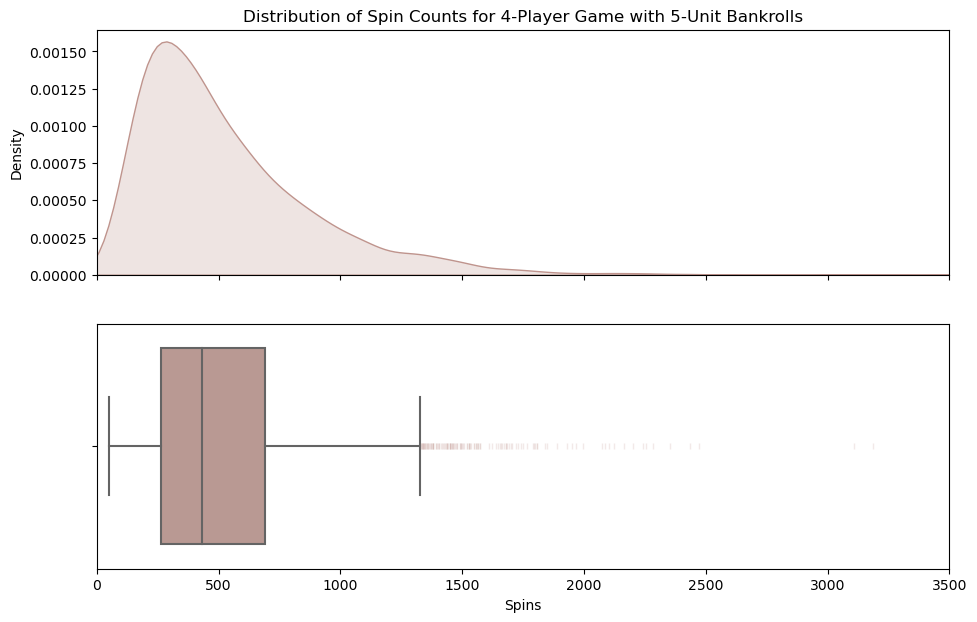

In [51]:
players_4 = (dreidel['players'] == 4)
units_10 = (dreidel['bankroll_start'] == 10)

fig, axs = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

sns.kdeplot(
    x='spins',
    common_norm=False,
    fill=True,
    data=dreidel[players_4 & units_10],
    ax=axs[0],
    color='#BF948D'
)

sns.boxplot(
    x='spins',
    data=dreidel[players_4 & units_10],
    ax=axs[1],
    showfliers=True,
    flierprops=dict(marker='|', markersize=5, markeredgecolor='#BF948D', alpha=.2),
    color='#BF948D'
)

axs[0].set_title('Distribution of Spin Counts for 4-Player Game with 5-Unit Bankrolls')
axs[1].set_xlabel('Spins')
axs[1].set_xlim(0, 3500);

There are a few things to note here right off the bat:
<ul>
    <li>First off, that's a lot of spins! The median number of spins looks close to 500.</li>
    <li>The spin counts for dreidel games are not normally distributed but are positively skewed, meaning that there are outlier games with upwards of 1,500 spins that are pulling the distribution in that direction.</li>
    <li>There's a huge amount of variance in this distribution, which the box plot (below) makes particularly evident: while the middle 50% of games require somewhere around 250–700 spins, there clearly a lot of games that, under these conditions, progress relatively rapidly (less than 200 spins) and just as many that take a very long time indeed.</li>
</ul>

Let's look at 4-player games more generally to see how the distribution chnages as the starting bankroll amount varies.